
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * historical wave and water level conditions
  * emulator output - synthetic wave and water level conditions
  
in this notebook:
  * plot the historical and synthetic values of the analyzed variables
  * generation of hourly values of the synthetic time series
  
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# for user inputs
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog

# for input configuration
import sys
sys.path.append('../../..')  # Appending parent directory to Python path
from input_configuration import *

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator_lim_hydrograph_days import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, repair_times_hourly, add_max_storms_mask, fast_reindex_hourly_nsim

# slp, windu, windv has different names for observed data and simulated data, so use two functions
from teslakit.plotting.outputs import Plot_Complete, Plot_Complete_sim



## Database and Site parameters

In [2]:
# Teslakit database

p_data = p_data_input
db = Database(p_data)

# make a new site
db.MakeNewSite(site_name)

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

n_sims_DWTs = num_sims_input/10 #originally 100 -PF
print(CE)

Teslakit Site already exists at C:/Users/fergusonpc/Teslakit-SF-Final\sites\SF_Test5



## Historical Waves and Climate Data

In [3]:
# generate historical covariates hourly data (AWT, MJO, DWT, MMSL, AT) 
CVS = db.Generate_HIST_Covariates()

# load historical waves families
WVS = db.Load_WAVES_hist()


In [4]:
# generate historical covariates hourly data (AWT, MJO, DWT, MMSL, AT) 
CVS = db.Generate_HIST_Covariates()
print(CVS)

# load historical waves families
WVS = db.Load_WAVES_hist()
print (WVS)
WVS = WVS.drop(['Hs', 'Tp', 'Dir', 'TC_category'])
# print (WVS)

# add extra var
ss = db.Load_storm_surge()
xtr_var= ss.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['SS'] = xtr_var.ss

# add extra var
PRMSL_L101 = db.Load_sea_level_pressure()
xtr_var= PRMSL_L101.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['SLP'] = xtr_var.PRMSL_L101

# add extra var
U_GRD_L103 = db.Load_wind_u()
xtr_var= U_GRD_L103.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['WNDU'] = xtr_var.U_GRD_L103

# add extra var
V_GRD_L103 = db.Load_wind_v()
xtr_var= V_GRD_L103.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['WNDV'] = xtr_var.V_GRD_L103

# aggregate waves families
WVS_agr = Aggregate_WavesFamilies(WVS, 'max_energy')

WVS = xr.merge([WVS, WVS_agr])
print(WVS)

# resample to hourly data
WVS = WVS.resample(time='1h').pad()
print(WVS)

# Combine historical data
HIST = xr.combine_by_coords([CVS, WVS])
print(HIST)

# set AT reference level (mean at 0)
HIST['AT'] = HIST['AT'] - np.nanmean(HIST['AT'])
# calculate AWL, TWL and level
HIST['AWL'] = AWL(HIST['Hs'], HIST['Tp'])

HIST['TWL'] = HIST['AWL'] + HIST['AT'] + HIST['MMSL']

HIST['level'] = HIST['AT'] + HIST['MMSL']

# add mask for max_storms times
HIST = add_max_storms_mask(HIST, CE.WVS_MS.time.values)

# store hourly historical offshore data
db.Save_HIST_OFFSHORE(HIST)

print(HIST)

<xarray.Dataset>
Dimensions:  (time: 1078249)
Coordinates:
  * time     (time) datetime64[ns] 1897-08-01 1897-08-01T01:00:00 ... 2020-08-03
Data variables:
    AT       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    AWT      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    DWT      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    MJO      (time) float64 nan nan nan nan nan nan ... 25.0 25.0 25.0 25.0 20.0
    MMSL     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
<xarray.Dataset>
Dimensions:      (time: 350640)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
   

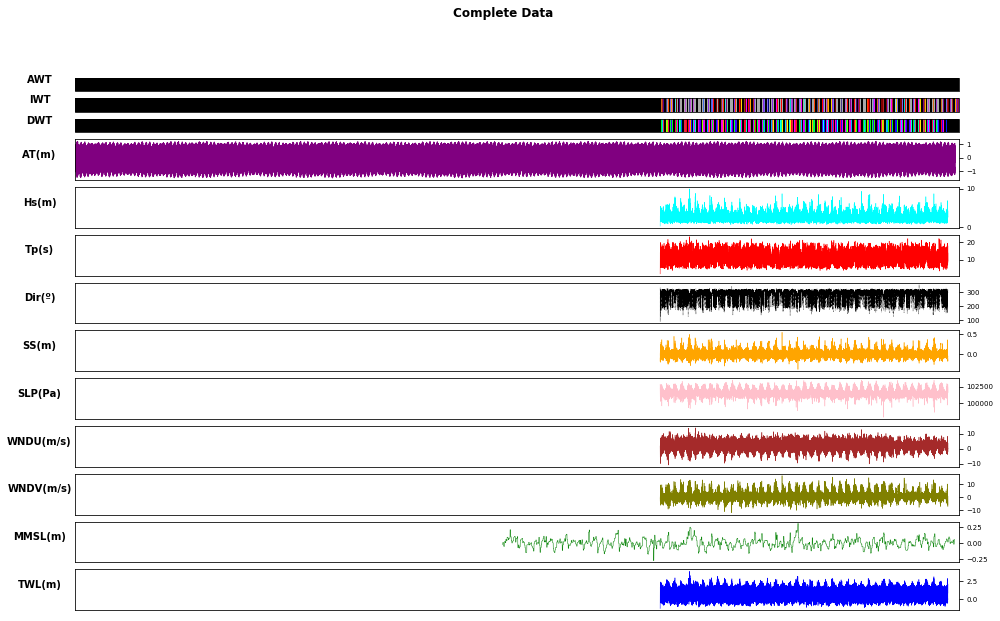

In [5]:
# Plot Historical 
Plot_Complete(HIST);



## Simulated Waves and Climate Data

In [6]:
def waves_hourly(CE, n_sim, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - select one DWTs-WVS Climate emulator simulations
    - aggregate simulated waves storms
    - generate hourly hydrographs
    
    return xarray.Dataset with dims: time (hourly)
    '''

    # Load DWT --> WVS, TCs simulation 
    WVS_sim, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n_sim) 
#     print(WVS_sim)

    WVS_sim = WVS_sim.isel(n_sim = n_sim_ce) 
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  
    TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)
    
    # aggregate waves families
    WVS_agr = Aggregate_WavesFamilies(WVS_upd, 'max_energy')
    WVS_agr['sea_Hs'] = (['time'],WVS_upd.sea_Hs.values)
    WVS_agr['sea_Tp'] = (['time'],WVS_upd.sea_Tp.values)
    WVS_agr['sea_Dir'] = (['time'],WVS_upd.sea_Dir.values)
    WVS_agr['swell_1_Hs'] = (['time'],WVS_upd.swell_1_Hs.values)
    WVS_agr['swell_1_Tp'] = (['time'],WVS_upd.swell_1_Tp.values)
    WVS_agr['swell_1_Dir'] = (['time'],WVS_upd.swell_1_Dir.values)
    WVS_agr['swell_2_Hs'] = (['time'],WVS_upd.swell_2_Hs.values)
    WVS_agr['swell_2_Tp'] = (['time'],WVS_upd.swell_2_Tp.values)
    WVS_agr['swell_2_Dir'] = (['time'],WVS_upd.swell_2_Dir.values)

    WVS_agr['storm_surge'] = (['time'],WVS_sim.storm_surge.values)
    WVS_agr['sea_level_pressure'] = (['time'],WVS_sim.sea_level_pressure.values)

    WVS_agr['wind_u'] = (['time'],WVS_sim.wind_u.values)
    WVS_agr['wind_v'] = (['time'],WVS_sim.wind_v.values)

    # calculate intradaily hourly hydrographs for simulated storms
    WVS_h = Intradaily_Hydrograph(WVS_agr, TCS_sim)
        
    # repair times: remove duplicates (if any)
    WVS_h = repair_times_hourly(WVS_h)
    
    # add mask for max_storms times
    WVS_h = add_max_storms_mask(WVS_h, WVS_upd.time.values)

    # overwrite TC SS with hourly SS
    WVS_h= WVS_h.drop('SS')
    WVS_h['SS']=WVS_h['storm_surge']
    WVS_h = WVS_h.drop('storm_surge')
    
    return WVS_h
    

In [7]:
# generate simulation covariates hourly data 
CVS = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)

In [8]:
# iterate simulations
for n in range(n_sims_DWTs):
 
    # select covariates simulation
    CVS_s = CVS.sel(n_sim=n)

    # generate hourly waves
    WVS_s = waves_hourly(CE, n)
    
    # merge all data
    d1, d2 = xds_limit_dates([WVS_s, CVS_s])
    WVS_s = WVS_s.sel(time = slice(d1, d2))
    CVS_s = CVS_s.sel(time = slice(d1, d2))
    SIM = xr.combine_by_coords([WVS_s, CVS_s])

    # set AT reference level (mean at 0)
    SIM['AT'].values[:] = SIM['AT'] - np.nanmean(SIM['AT'])
    
    # calculate AWL, TWL and level
    SIM['AWL'] = AWL(SIM['Hs'], SIM['Tp'])
    SIM['TWL'] = SIM['AWL'] + SIM['SS'] + SIM['AT'] + SIM['MMSL']
    SIM['level'] = SIM['SS'] + SIM['AT'] + SIM['MMSL']
    
    # store hourly simulation offshore data
    db.Save_SIM_OFFSHORE(SIM, n)
    
    print('simulation {0} processed.'.format(n))
#     print(SIM)
    

simulation 0 processed.
simulation 1 processed.
simulation 2 processed.
simulation 3 processed.
simulation 4 processed.
simulation 5 processed.
simulation 6 processed.
simulation 7 processed.
simulation 8 processed.
simulation 9 processed.


<xarray.Dataset>
Dimensions:             (time: 4391665)
Coordinates:
  * time                (time) int32 266616 266617 266618 ... 4658279 4658280
Data variables:
    AT                  (time) float32 0.27276146 -0.0753994 ... 0.23668599
    AWL                 (time) float32 0.8467204 0.8964633 ... 0.40543556
    AWT                 (time) float32 5.0 5.0 5.0 5.0 5.0 ... 4.0 4.0 4.0 6.0
    Dir                 (time) float32 292.4534 292.4534 ... 305.51132 315.5597
    DWT                 (time) float32 5.0 5.0 5.0 5.0 ... 11.0 11.0 11.0 11.0
    Hs                  (time) float32 1.4979559 1.6791288 ... 1.6394365
    level               (time) float32 0.14297622 -0.20518464 ... 0.20883314
    max_storms          (time) float32 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    MJO                 (time) float32 23.0 23.0 23.0 23.0 ... 25.0 25.0 25.0
    MMSL                (time) float32 -0.058406156 ... -0.062557235
    sea_Dir             (time) float32 nan nan nan ... 319.18494 315.559

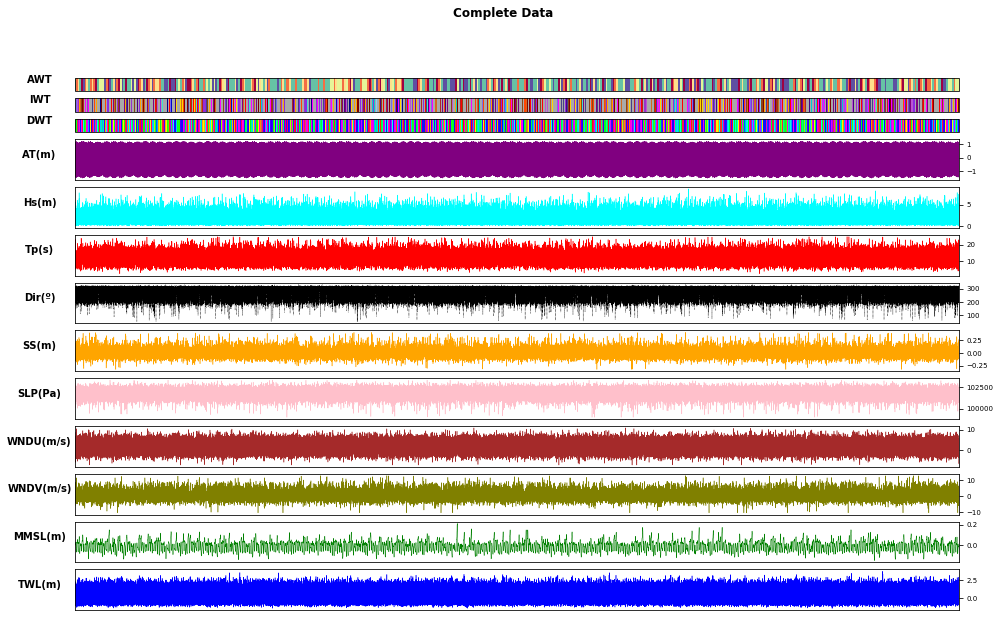

In [9]:
# Plot one Simulation 

n_sim = 0
SIM_p = db.Load_SIM_OFFSHORE(n_sim)
print(SIM_p)

# SIM_p.Dir[SIM_p.Dir>180] = SIM_p.Dir[SIM_p.Dir>180] -360
Plot_Complete_sim(SIM_p);
